<a href="https://colab.research.google.com/github/slneha/ECE684FinalProj/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 350MB/s]


In [ ]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
for airline in df["airline"].unique():
    example = df[df["airline"] == airline][["airline", "text"]].iloc[0]
    print("="*80)
    print(f"AIRLINE: {airline}")
    print("RAW TEXT:")
    print(example["text"])
    print("="*80, "\n")

AIRLINE: Virgin America
RAW TEXT:
@VirginAmerica What @dhepburn said.

AIRLINE: United
RAW TEXT:
@united thanks

AIRLINE: Southwest
RAW TEXT:
@SouthwestAir still waiting. Just hit one hour.

AIRLINE: Delta
RAW TEXT:
@JetBlue Yesterday on my way from EWR to FLL just after take-off. :)
#wheelsup #JetBlueSoFly http://t.co/9xkiy0Kq2j

AIRLINE: US Airways
RAW TEXT:
@USAirways  is there a better time to call? My flight is on Friday and I need to change it. Worried I may be on hold until then.

AIRLINE: American
RAW TEXT:
@AmericanAir why would I even consider continuing your point program when I received no perks or continued bad customer service? #senseless



In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.1 MB/s eta 0:00:00


In [ ]:
import re
import contractions
import html

# Known airline handles in the US Airline Sentiment dataset
AIRLINE_HANDLES = {
    "virginamerica",
    "usairways",
    "united",
    "americanair",
    "southwestair",
    "delta",
}

def replace_mention(match):
    handle = match.group(1)  # without '@'
    # Keep airline handles, normalize everything else to @user
    if handle.lower() in AIRLINE_HANDLES:
        return f"@{handle}"
    else:
        return "@user"

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)                               # decode HTML entities
    text = contractions.fix(text)                            # expand contractions
    text = re.sub(r"http\S+|www\S+", " <URL> ", text)        # Replace URLs with a placeholder token
    text = re.sub(r"@(\w+)", replace_mention, text)          # Handles mentions
    text = re.sub(r"#(\w+)", r"\1", text)    # "#oscars2016" -> "oscars2016"
    text = re.sub(r"\s+", " ", text)                         # multi spaces
    # Remove unprintable / non-unicode junk characters
    text = "".join(ch for ch in text if ch.isprintable())

    return text.strip()


# Apply
df["clean_text"] = df["text"].apply(preprocess_text)
df = df.drop_duplicates(subset='tweet_id')
df = df[df['clean_text'].notnull()]
df = df[df['clean_text'].str.strip() != '']

# Quick sanity-check
pd.set_option("display.max_colwidth", 120)  # show longer snippets
display(df[["text", "clean_text"]].sample(5, random_state=42))

# Count tweets that became empty after cleaning (should be 0)
empty_cnt = (df["clean_text"].str.len() == 0).sum()
print(f"Empty after cleaning: {empty_cnt}")

,text,clean_text
8709,@JetBlue I understand but everyone said different things and there was a flight out Late Flightr that night but only...,@user I understand but everyone said different things and there was a flight out Late Flightr that night but only on...
6501,@SouthwestAir can you make a premium wifi that I can pay $30 for that is decent? #slow-fi,@SouthwestAir can you make a premium wifi that I can pay $30 for that is decent? slow-fi
2366,@united No wonder the cabin is filthy. #badservice,@united No wonder the cabin is filthy. badservice
6291,@SouthwestAir When does PV get approved? I am ready to go!!,@SouthwestAir When does PV get approved? I am ready to go!!
169,@VirginAmerica to jump into the Dallas-Austin market - @Dallas_News http://t.co/EwwGi97gdx,@VirginAmerica to jump into the Dallas-Austin market - @user <URL>


Empty after cleaning: 0


/tmp/ipython-input-824791052.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


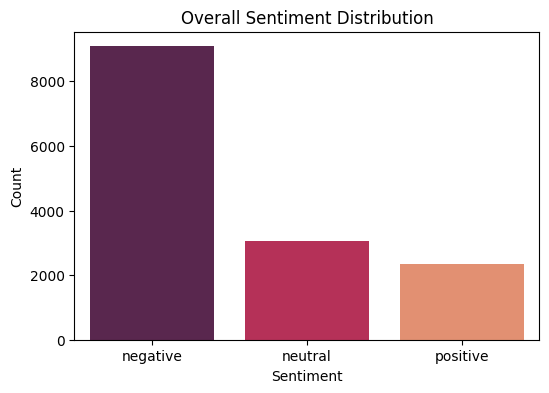

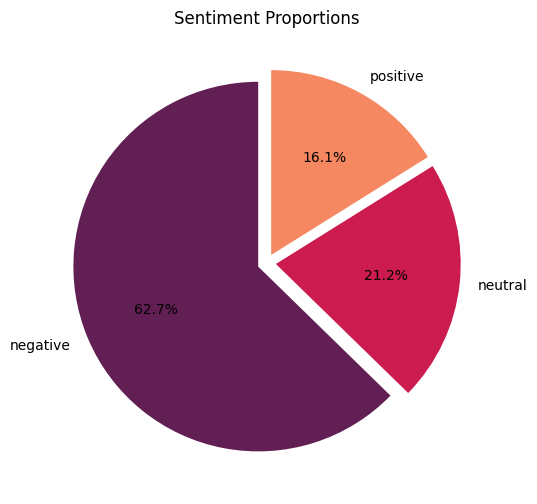

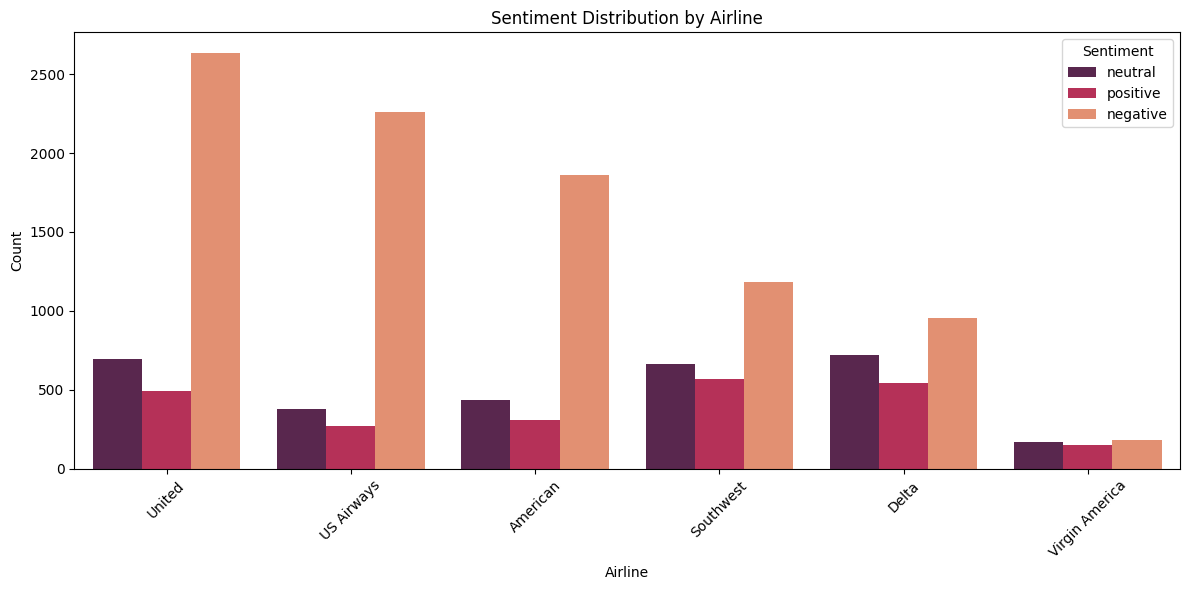

In [ ]:
palette_name = "rocket"

# 1️⃣ Overall bar chart
plt.figure(figsize=(6,4))
sns.countplot(
    x="airline_sentiment",
    data=df,
    order=["negative","neutral","positive"],
    palette=palette_name
)
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# 2️⃣ Overall pie chart
plt.figure(figsize=(6,6))
colors = sns.color_palette(palette_name, 3)
(df["airline_sentiment"]
   .value_counts()
   .loc[["negative","neutral","positive"]]
   .plot.pie(
       autopct="%1.1f%%",
       colors=colors,
       startangle=90,
       explode=[0.05]*3
   )
)
plt.title("Sentiment Proportions")
plt.ylabel("")
plt.show()

# 3️⃣ Sentiment per airline
plt.figure(figsize=(12,6))
sns.countplot(
    x="airline",
    hue="airline_sentiment",
    data=df,
    order=df["airline"].value_counts().index,
    palette=palette_name
)
plt.title("Sentiment Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

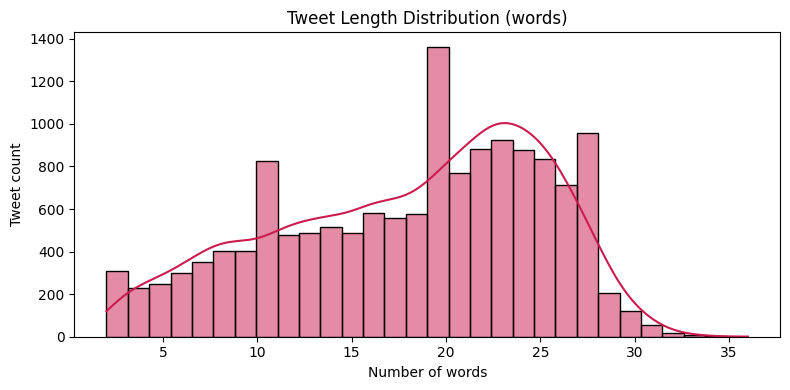

/tmp/ipython-input-1268502208.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


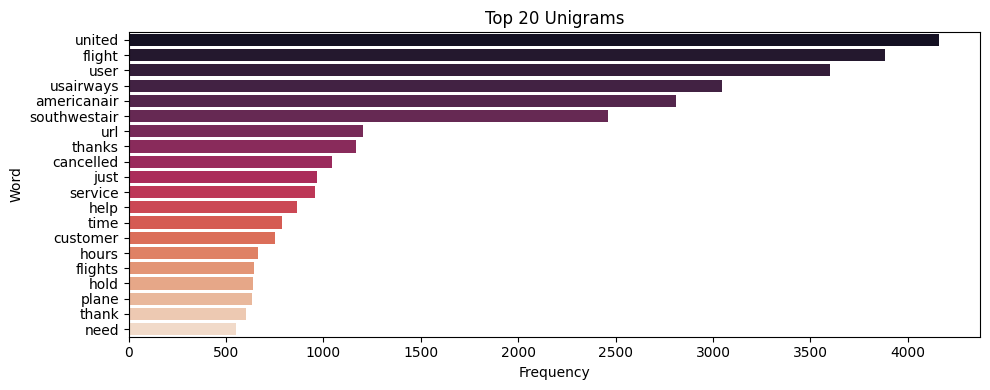

/tmp/ipython-input-1268502208.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


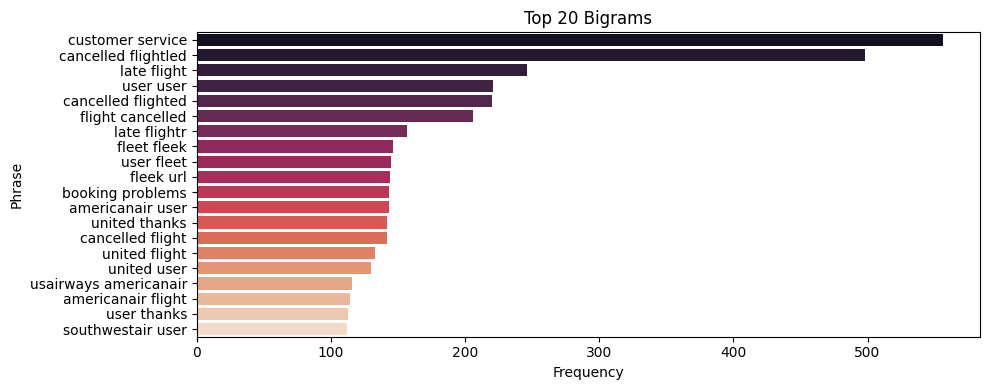

In [ ]:
# 1️⃣ Compute tweet-lengths (in words)
df["text_length"] = df["clean_text"].str.split().apply(len)

# 1a. Length histogram
plt.figure(figsize=(8,4))
sns.histplot(
    df["text_length"],
    bins=30,
    kde=True,
    color=sns.color_palette("rocket", 1)[0]
)
plt.title("Tweet Length Distribution (words)")
plt.xlabel("Number of words")
plt.ylabel("Tweet count")
plt.tight_layout()
plt.show()

# 2️⃣ Top unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv_uni = CountVectorizer(stop_words="english", max_features=20)
uni_matrix = cv_uni.fit_transform(df["clean_text"])
uni_counts = np.array(uni_matrix.sum(axis=0)).ravel()
uni_words  = cv_uni.get_feature_names_out()
uni_series = pd.Series(uni_counts, index=uni_words).sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(
    x=uni_series.values,
    y=uni_series.index,
    palette="rocket"
)
plt.title("Top 20 Unigrams")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# 3️⃣ Top bigrams
cv_bi = CountVectorizer(stop_words="english", ngram_range=(2,2), max_features=20)
bi_matrix = cv_bi.fit_transform(df["clean_text"])
bi_counts = np.array(bi_matrix.sum(axis=0)).ravel()
bi_words  = cv_bi.get_feature_names_out()
bi_series = pd.Series(bi_counts, index=bi_words).sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(
    x=bi_series.values,
    y=bi_series.index,
    palette="rocket"
)
plt.title("Top 20 Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Phrase")
plt.tight_layout()
plt.show()

In [ ]:
df['clean_text'].isnull().sum()


np.int64(0)

In [ ]:
df["clean_text"].duplicated().sum()


np.int64(93)

In [ ]:
df = df.drop_duplicates(subset="clean_text", keep="first")
df["clean_text"].duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14392 entries, 0 to 14639
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14392 non-null  int64  
 1   airline_sentiment             14392 non-null  object 
 2   airline_sentiment_confidence  14392 non-null  float64
 3   negativereason                9075 non-null   object 
 4   negativereason_confidence     10402 non-null  float64
 5   airline                       14392 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14392 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14392 non-null  int64  
 10  text                          14392 non-null  object 
 11  tweet_coord                   1002 non-null   object 
 12  tweet_created                 14392 non-null  object 
 13  tweet_

#### Dropping these columns
- airline_sentiment_confidence: confidence scores are not used in cluster-level sentiment calculations
- negativereason_confidence: same as above
- airline_sentiment_gold: mostly missing values
- negativereason_gold: mostly missing values
- name: Twitter display name offers no semantic value
- retweet_count: popularity does not affect the meaning of the tweet
- tweet_created: timeline information is not used for embedding-based clustering
- tweet_location: inconsistent text field not related to tweet semantics
- user_timezone: noisy and unrelated for embedding and clustering
- text_length: becomes irrelevant once the text is converted into embeddings

In [ ]:
df_final= df[["tweet_id", "text", "clean_text", "airline", "airline_sentiment"]]
df_final.head()

,tweet_id,text,clean_text,airline,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,@VirginAmerica What @user said.,Virgin America,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,@VirginAmerica plus you have added commercials to the experience... tacky.,Virgin America,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,@VirginAmerica I did not today... Must mean I need to take another trip!,Virgin America,neutral
3,570301031407624196,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have littl...","@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little r...",Virgin America,negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing about it,@VirginAmerica and it is a really big bad thing about it,Virgin America,negative


In [ ]:
df_final.to_csv("Tweets_clean.csv", index=False)